In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
path_to_data = "./reference/"

X_test = np.load(f"{path_to_data}X.dat_test.npy")
Y_test = np.load(f"{path_to_data}Y.dat_test.npy")

In [4]:
X_test_tensor = torch.tensor(X_test[:, np.newaxis], dtype=torch.float32, device=device)
Y_test_tensor = torch.tensor(Y_test[:, np.newaxis], dtype=torch.float32, device=device)

In [5]:
# create dataset
test_data = TensorDataset(X_test_tensor, Y_test_tensor)

batchsize = 64
# batchsize = test_data.tensors[0].shape[0]
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=True, drop_last=True)

In [6]:
def createLevel3FullyConvDropoutNet(channels):

    class Level3FullyConvDropoutNet(nn.Module):
        def __init__(self):
            super(Level3FullyConvDropoutNet, self).__init__()

            # Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(1, channels[0], kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(channels[0]),
                nn.Dropout2d(p=0.2),

                nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.BatchNorm2d(channels[1]),
                nn.Dropout2d(p=0.2),

                nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.BatchNorm2d(channels[2]),
            )
            
            # Decoder
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(channels[2], channels[1], kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.BatchNorm2d(channels[1]),

                nn.ConvTranspose2d(channels[1], channels[0], kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
                nn.BatchNorm2d(channels[0]),

                nn.ConvTranspose2d(channels[0], 1, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
            )

        def forward(self, x: torch.Tensor):
            x = self.encoder(x)
            x = self.decoder(x)
            return x

    # Instantiate the network
    net = Level3FullyConvDropoutNet()

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-2)

    return net, criterion, optimizer

In [7]:
channel_configuration = (15, 24, 33)
net, _, _ = createLevel3FullyConvDropoutNet(channel_configuration)

net.load_state_dict(
    torch.load(
        "../archive/Level3FullyConvDropoutNet_99.6498/net.pt",
        weights_only=True,
    )
)

<All keys matched successfully>

In [8]:
# Create FCNN
class LargeNNv2(nn.Module):
    def __init__(self):
        super(LargeNNv2, self).__init__()
        self.fc1 = nn.Linear(49, 1235)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1235, 768)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(768, 532)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(532, 149)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(149, 98)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(98, 49)  # Output layer

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.relu5(self.fc5(x))
        x = self.fc6(x)
        return x

fcnn = LargeNNv2()

fcnn.load_state_dict(torch.load("../reference/model/collaboratory/m_300.pth", weights_only=True))

<All keys matched successfully>

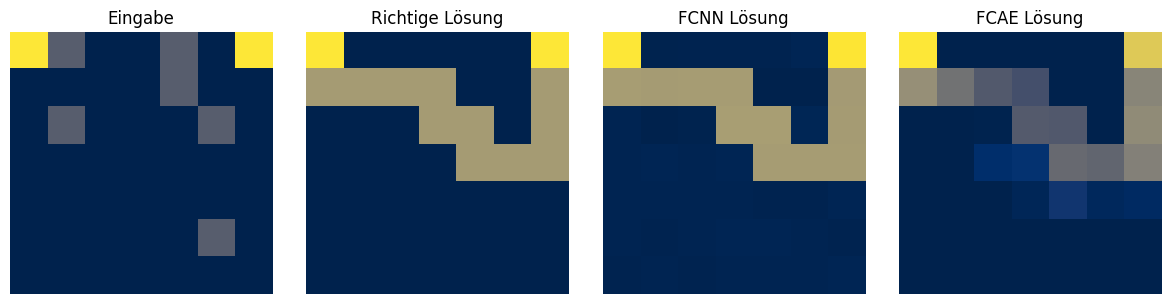

In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# **Manuell auswählbarer Index**
selected_index = 17  # Hier den gewünschten Index eintragen

# **Sicherstellen, dass der Index gültig ist**
if selected_index >= len(X_test):
    raise ValueError(f"Der Index ist zu groß! Maximaler gültiger Index: {len(X_test)-1}")

# **Daten auf das richtige Gerät laden**
X_selected = torch.tensor(X_test[selected_index:selected_index+1, np.newaxis], dtype=torch.float32, device=device)
y_selected = torch.tensor(Y_test[selected_index:selected_index+1, np.newaxis], dtype=torch.float32, device=device)

# **Modelle auf das richtige Gerät setzen**
net.to(device)
fcnn.to(device)
net.eval()

# **Vorhersagen berechnen**
y_hat_fcae = net(X_selected).squeeze().detach().cpu().numpy()
y_hat_fcnn = fcnn(X_selected.view(X_selected.shape[0], -1)).view(X_selected.shape).squeeze().detach().cpu().numpy()

# **Plot erstellen (1 Zeile, 4 Spalten)**
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# **Eingabe-Labyrinth**
axes[0].imshow(X_selected[0, 0].cpu().numpy(), cmap="cividis")
axes[0].set_title(f"Eingabe", fontsize=12)
axes[0].axis("off")

# **Richtige Lösung**
axes[1].imshow(y_selected[0, 0].cpu().numpy(), cmap="cividis")
axes[1].set_title("Richtige Lösung", fontsize=12)
axes[1].axis("off")

# **Vorhersage von FCNN**
axes[2].imshow(y_hat_fcnn, cmap="cividis")
axes[2].set_title("FCNN Lösung", fontsize=12)
axes[2].axis("off")

# **Vorhersage von FCAE**
axes[3].imshow(y_hat_fcae, cmap="cividis")
axes[3].set_title("FCAE Lösung", fontsize=12)
axes[3].axis("off")

# **Layout anpassen und speichern**
plt.tight_layout()
plt.savefig(f"./Einzelnes_Labyrinth_{selected_index}.png", bbox_inches="tight", pad_inches=0)
plt.show()


In [ ]:
# 17, 8